In [20]:
import numpy as np
import pandas as pd
import pygplates
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math
import cmcrameri.cm as cm

#Check that we have the latest version of pygplates
from importlib.metadata import version
version('pygplates') #For this code to work, the version of pygplates should be 1.0.0

'1.0.0rc1'

Frame work of the code :

- at time t :
- get coordinates of subduction boundaries and the corresponding subducting plate ID
- calculate spherical velocity at subduction boundary
- project it on subduction length or to normal vector
- calculate subduction flux for current segment

For more details see the report.

### Data Extraction

In [256]:
anchor_plate = 1 # 4 ?

L_plate_model = ['MA16', 'MU16', 'S12', 'T19']

plate_model_label = ['Matthews et al. (2016)', 'Müller et al. (2016)', 'Seton et al. (2012)', 'Torsvik et al. (2019)']

#colors for plots
cmap=cm.managua
colors = cmap([0,0.33,0.66,1])

plate_model = 'MA16'

rotation_model = 'plate_models/'+plate_model+'/'+plate_model+'_rotation_model.rot'
plate_poly = 'plate_models/'+plate_model+'/'+plate_model+'_dynamic_polygons.gpml'

start=0
stop=250
# time = 0 #we fix time first, we can iterate the whole code over time later
delta_time = 5

rho=3
thickness=100

In [171]:
#Let's try using shared topologies instead

#Create DataFrame to store our data
df=pd.DataFrame()

#Create a topological model from the topological plate polygon features (can also include deforming networks)
# and the rotation model.

poly_test=[]
test=0

for time in range(start, stop+delta_time, delta_time):

    '''
    if time>250:
        plate_poly=plate_poly_410_250
        rotation_model=rotation_model_410_250
    else:
        plate_poly=plate_poly_250_0
        rotation_model=rotation_model_250_0
        '''
    
        
    topological_model = pygplates.TopologicalModel(plate_poly, rotation_model)
    # Load one or more rotation files into a rotation model.
    rotation_model = pygplates.RotationModel(rotation_model)
    
    current_df=pd.DataFrame()
    points=[]
    sub_id=[]
    N=[]
    V=[]
    F=[]
    W=[]
    # Get a snapshot of our resolved topologies at the current 'time'.
    topological_snapshot = topological_model.topological_snapshot(time)
    # Extract the boundary sections between our resolved topological plate polygons (and deforming networks) from the current snapshot.
    shared_boundary_sections = topological_snapshot.get_resolved_topological_sections()
    
    # Iterate over the shared boundary sections of all resolved topologies.
    for shared_boundary_section in shared_boundary_sections:
    
        # Skip sections that are not subduction zones.
        # We're only interesting in closeness to subducting lines.
        if shared_boundary_section.get_feature().get_feature_type() != pygplates.FeatureType.gpml_subduction_zone:
            continue
    
        # Iterate over the shared sub-segments of the current subducting line.
        # These are the parts of the subducting line that actually contribute to topological boundaries.
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
    
            #print(shared_sub_segment.get_resolved_geometry()) #The subsegment contains a Polyline geometry!
    
            # Get the subducting resolved plate/network of the current shared sub-segment.
            subducting_plate_and_polarity = shared_sub_segment.get_subducting_plate(True)
            if subducting_plate_and_polarity:
                subducting_plate, subduction_polarity = subducting_plate_and_polarity
                subducting_plate_id = subducting_plate.get_feature().get_reconstruction_plate_id()
    
            # Get the rotation of plate 'domain_plate_id' from 'reconstruction_time + delta_time' to 'reconstruction_time'.
            equivalent_stage_rotation = rotation_model.get_rotation(time, subducting_plate_id, time + delta_time) # anchor_plate_id=anchor_plate)
    
            #extract great circle arc from polyline
            if test == 0:
                test=1
            else:
                test=0
    
            polyline_points = shared_sub_segment.get_resolved_geometry().get_points()  #change to .to_uniform_points(spacing_in_radians)
                                                                                        #to have a list of regularly spaced points
            
            # Iterate over consecutive points to create GreatCircleArc objects
             #for each great circle arc, get the midpoint and orthogonal vector
            for i in range(len(polyline_points) - 1):
                start_point = polyline_points[i]
                end_point = polyline_points[i + 1]
                arc = pygplates.GreatCircleArc(start_point, end_point)
                #great_circle_arcs.append(great_circle_arc)
                width = arc.get_arc_length() * pygplates.Earth.mean_radius_in_kms #width of subducting section in radians first, then in km
    
                if not arc.is_zero_length():
                    normal = arc.get_great_circle_normal()  #unit vector normal direction of the great circle this arc lies on
                    arc_midpoint = arc.get_arc_point(0.5)
                    
                    points.append(arc_midpoint)
                    sub_id.append(subducting_plate_id)
                    
                    # This is from 'reconstruction_time + delta_time' to 'reconstruction_time' on plate 'domain_plate_id'.
                    velocity_vector = pygplates.calculate_velocities(arc_midpoint, equivalent_stage_rotation, delta_time)
    
                    # project velocities to normal vector
    
                    flux_vect = np.abs(pygplates.Vector3D.dot(velocity_vector[0], normal)) * width * rho * thickness #We store the subduction flux in Pg/Myr
    
                    normal = pygplates.LocalCartesian.convert_from_geocentric_to_north_east_down(arc_midpoint,normal)
                    velocity_vector = pygplates.LocalCartesian.convert_from_geocentric_to_north_east_down(arc_midpoint,velocity_vector)

                    #print(np.isnan(velocity_vector[0]))
                    V.append(velocity_vector[0])
                    N.append(normal)
                    F.append(flux_vect)
                    W.append(width)
                    poly_test.append(test)   #the value of poly_test changes from 0 to 1 and vice versa for each iterated polyline

    #Store lon lat of midpoints, width of subduction segment, calculated flux, normal vector (to get direction of subduction), subducting plate id...
    # for current time:
                
    # Extract latitudes and longitudes by iterating through the list
    latitudes = [point.to_lat_lon()[0] for point in points]  # Get latitudes
    longitudes = [point.to_lat_lon()[1] for point in points]  # Get longitudes
    current_df[f'midpoint_lat_{time}'] = latitudes
    current_df[f'midpoint_lon_{time}'] = longitudes
    
    current_df[f'width_{time}'] = W
    current_df[f'subducting_plate_id_{time}'] = sub_id
    current_df[f'flux_{time}'] = F
    current_df[f'normal_{time}'] = N  #save the pygplates.Vector3D object directly
    current_df[f'velocity_{time}'] = V  #save the pygplates.Vector3D object directly

    
    df = pd.concat([df, current_df], axis=1)

df.to_csv('subduction_flux_data_'+plate_model+'.csv', index=False, na_rep='NA', float_format='%.4f')   # set format of NaNs + precision of floats and save

### Plotting

295 295
MA16


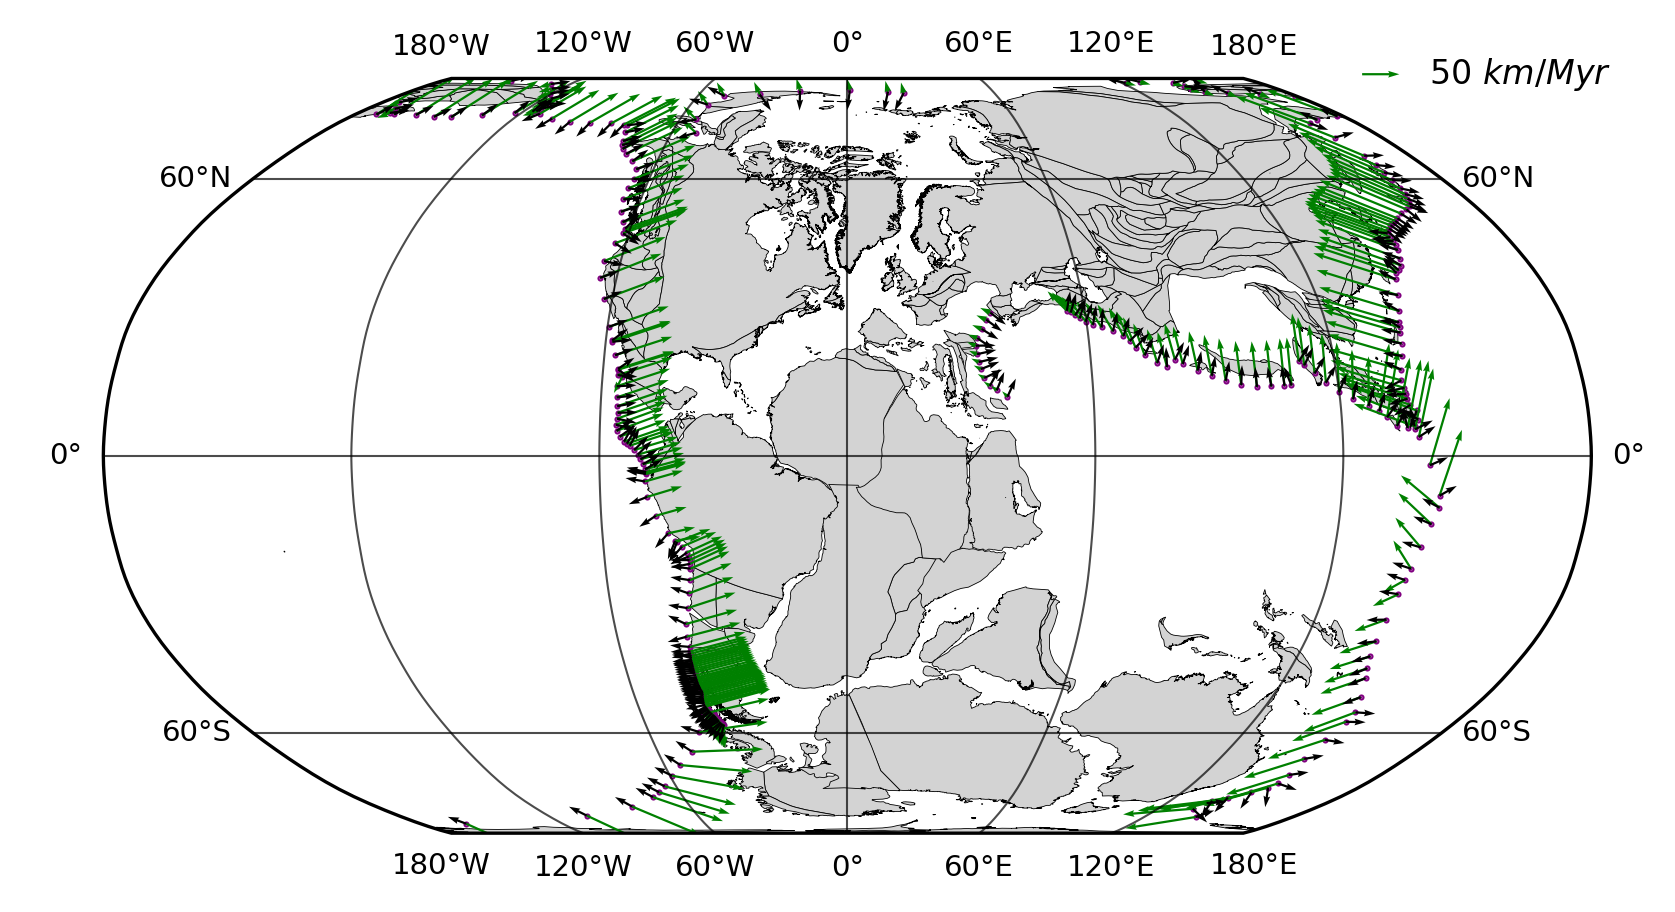

In [257]:
#Plot map at given time

from cartopy.io.shapereader import Reader
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import ast

df = pd.read_csv('subduction_flux_data_'+plate_model+'.csv') 

time = 150

df = df[[f'midpoint_lon_{time}', f'midpoint_lat_{time}', f'velocity_{time}', f'normal_{time}']]

df = df.dropna()

if time>250:
    plate_poly=plate_poly_410_250
    rotation_model=rotation_model_410_250
else:
    plate_poly=plate_poly_250_0
    rotation_model=rotation_model_250_0

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=0))

 # Load coastlines
coastlines = pygplates.FeatureCollection('C:/Users/ilyas/Documents/StageM1/Plate_driving_forces/Plate_model/Muller_etal_2016/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpml')

# It's a shapefile called 'reconstructed_50Ma.shp'.
export_filename = 'temp_coastlines.shp'
 
# Reconstruct the features to the reconstruction time and export them to a shapefile.
pygplates.reconstruct(coastlines, rotation_model, export_filename, time)
ax.set_global()

ax.add_geometries(Reader(export_filename).geometries(),
                      ccrs.PlateCarree(),
                      facecolor='lightgrey',zorder=1, edgecolor='black', linewidths=0.2)

ax.scatter(df[f'midpoint_lon_{time}'], df[f'midpoint_lat_{time}'], s=0.9, color='purple', marker='.', label='Subduction zone segment midpoints', transform=ccrs.PlateCarree())
#ax.legend(ncols=1, bbox_to_anchor=(0, 1.5), loc='lower left', fontsize='small')
ax.annotate(r'Time='+str(time)+'Ma', xy=(40, 260), size=10, xycoords='figure points', weight='bold')

# Convert the column to actual tuples
df[f'velocity_{time}'] = df[f'velocity_{time}'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip() else None
)

df[f'normal_{time}'] = df[f'normal_{time}'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip() else None
)

V = df[f'velocity_{time}'].to_numpy()

N = df[f'normal_{time}'].to_numpy()

n_x = [point[0] for point in N]  # Get latitudes
n_y = [point[1] for point in N]  # Get longitudes

v_x = [point[0] for point in V]  # Get latitudes
v_y = [point[1] for point in V]  # Get longitudes

print(len(v_x), len(df[f'midpoint_lat_{time}']))

V=ax.quiver(df[f'midpoint_lon_{time}'], df[f'midpoint_lat_{time}'], np.array(v_y), np.array(v_x), scale=2000, color='green', width=0.0015, transform=ccrs.PlateCarree())

N=ax.quiver(df[f'midpoint_lon_{time}'], df[f'midpoint_lat_{time}'], np.array(n_y), np.array(n_x), scale=75, color='black', width=0.0015, transform=ccrs.PlateCarree())

ax.quiverkey(V, 0.8, 0.76, 50, r'$50 \ km/Myr$', labelpos='E',coordinates='figure', fontproperties={'size' : 8})

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.7, linestyle='-')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.ylocator = mticker.FixedLocator([-60, 0, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 7, 'color': 'black'}
gl.xlabel_style = {'size': 7, 'color': 'black'}
gl.xlabels_top = False
gl.ylabels_left = False

print(plate_model)
plt.savefig('/figs/'+plate_model+'map_'+str(time)+'')
plt.show()

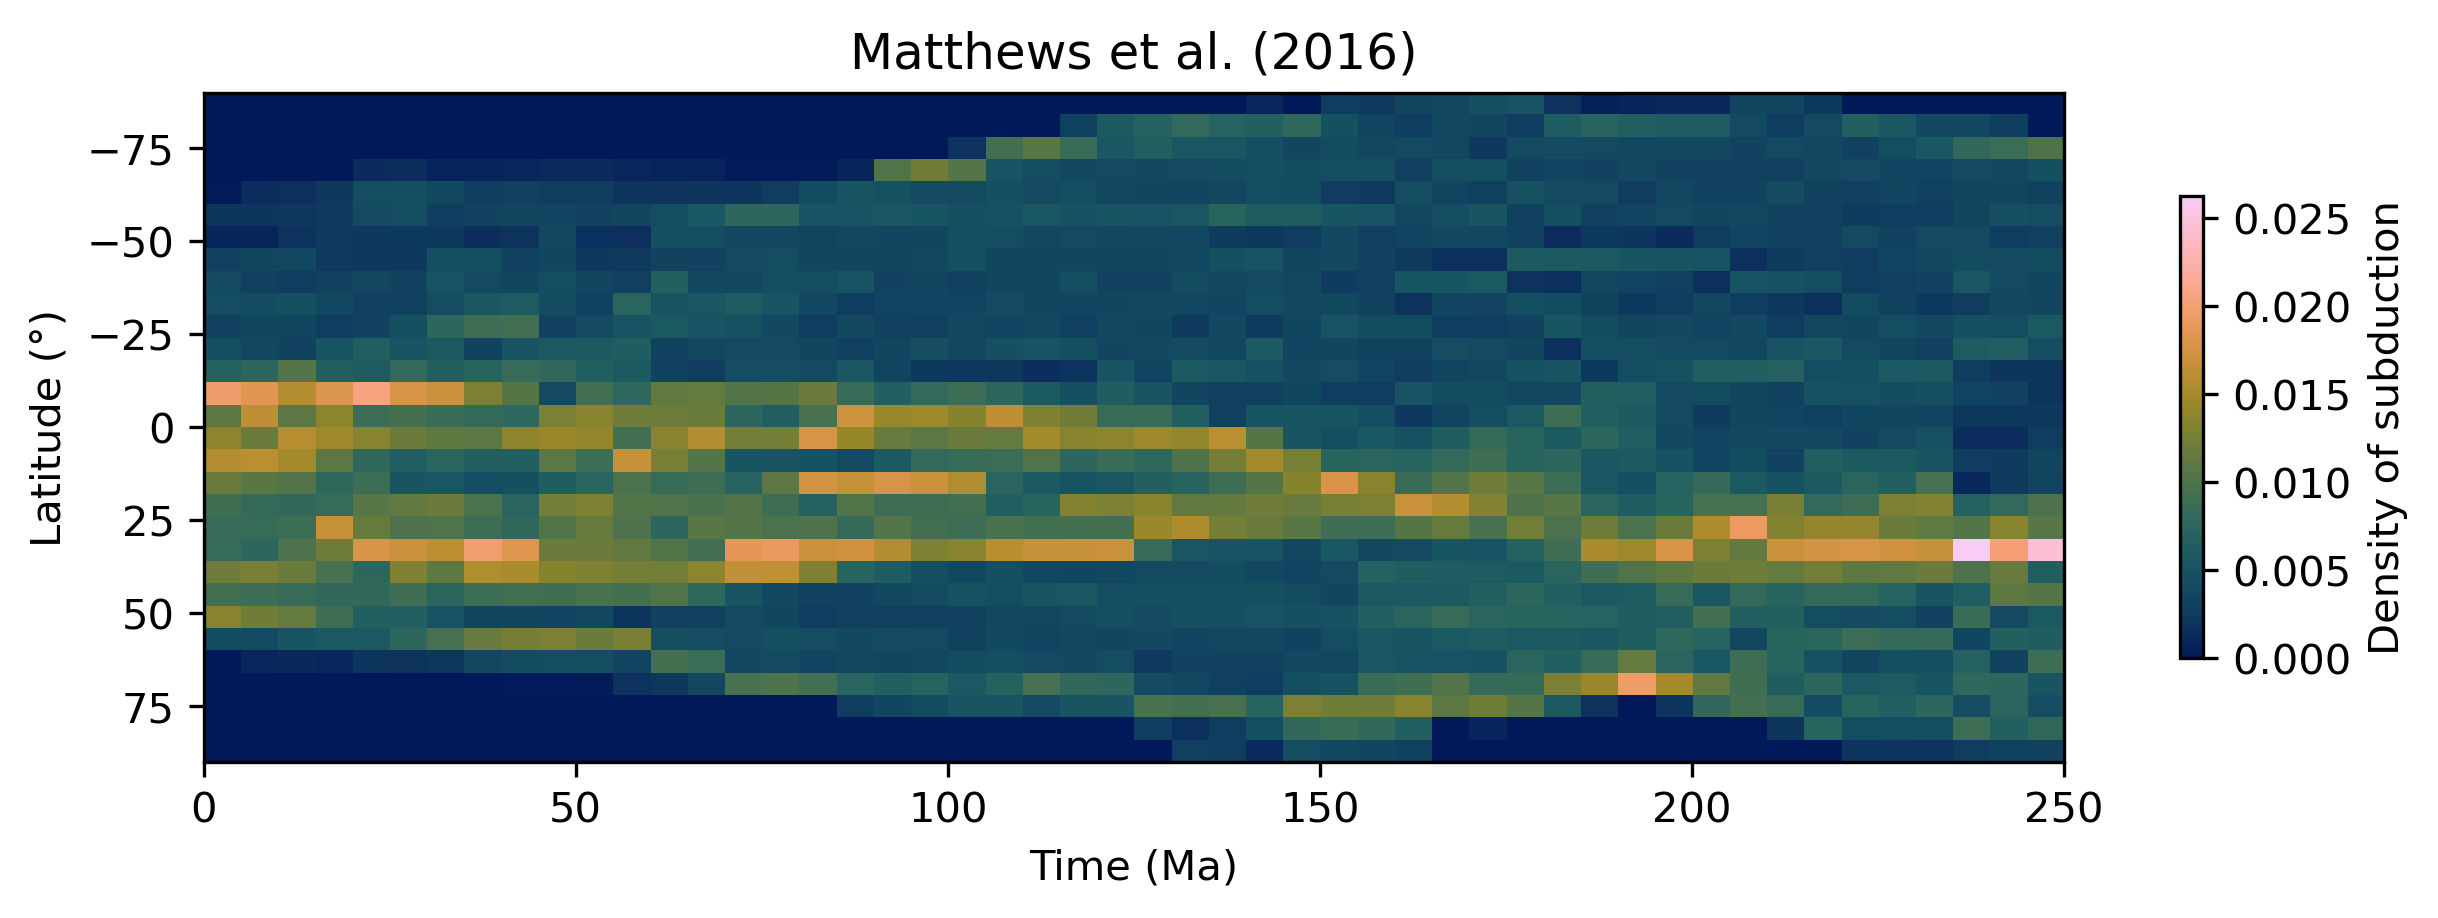

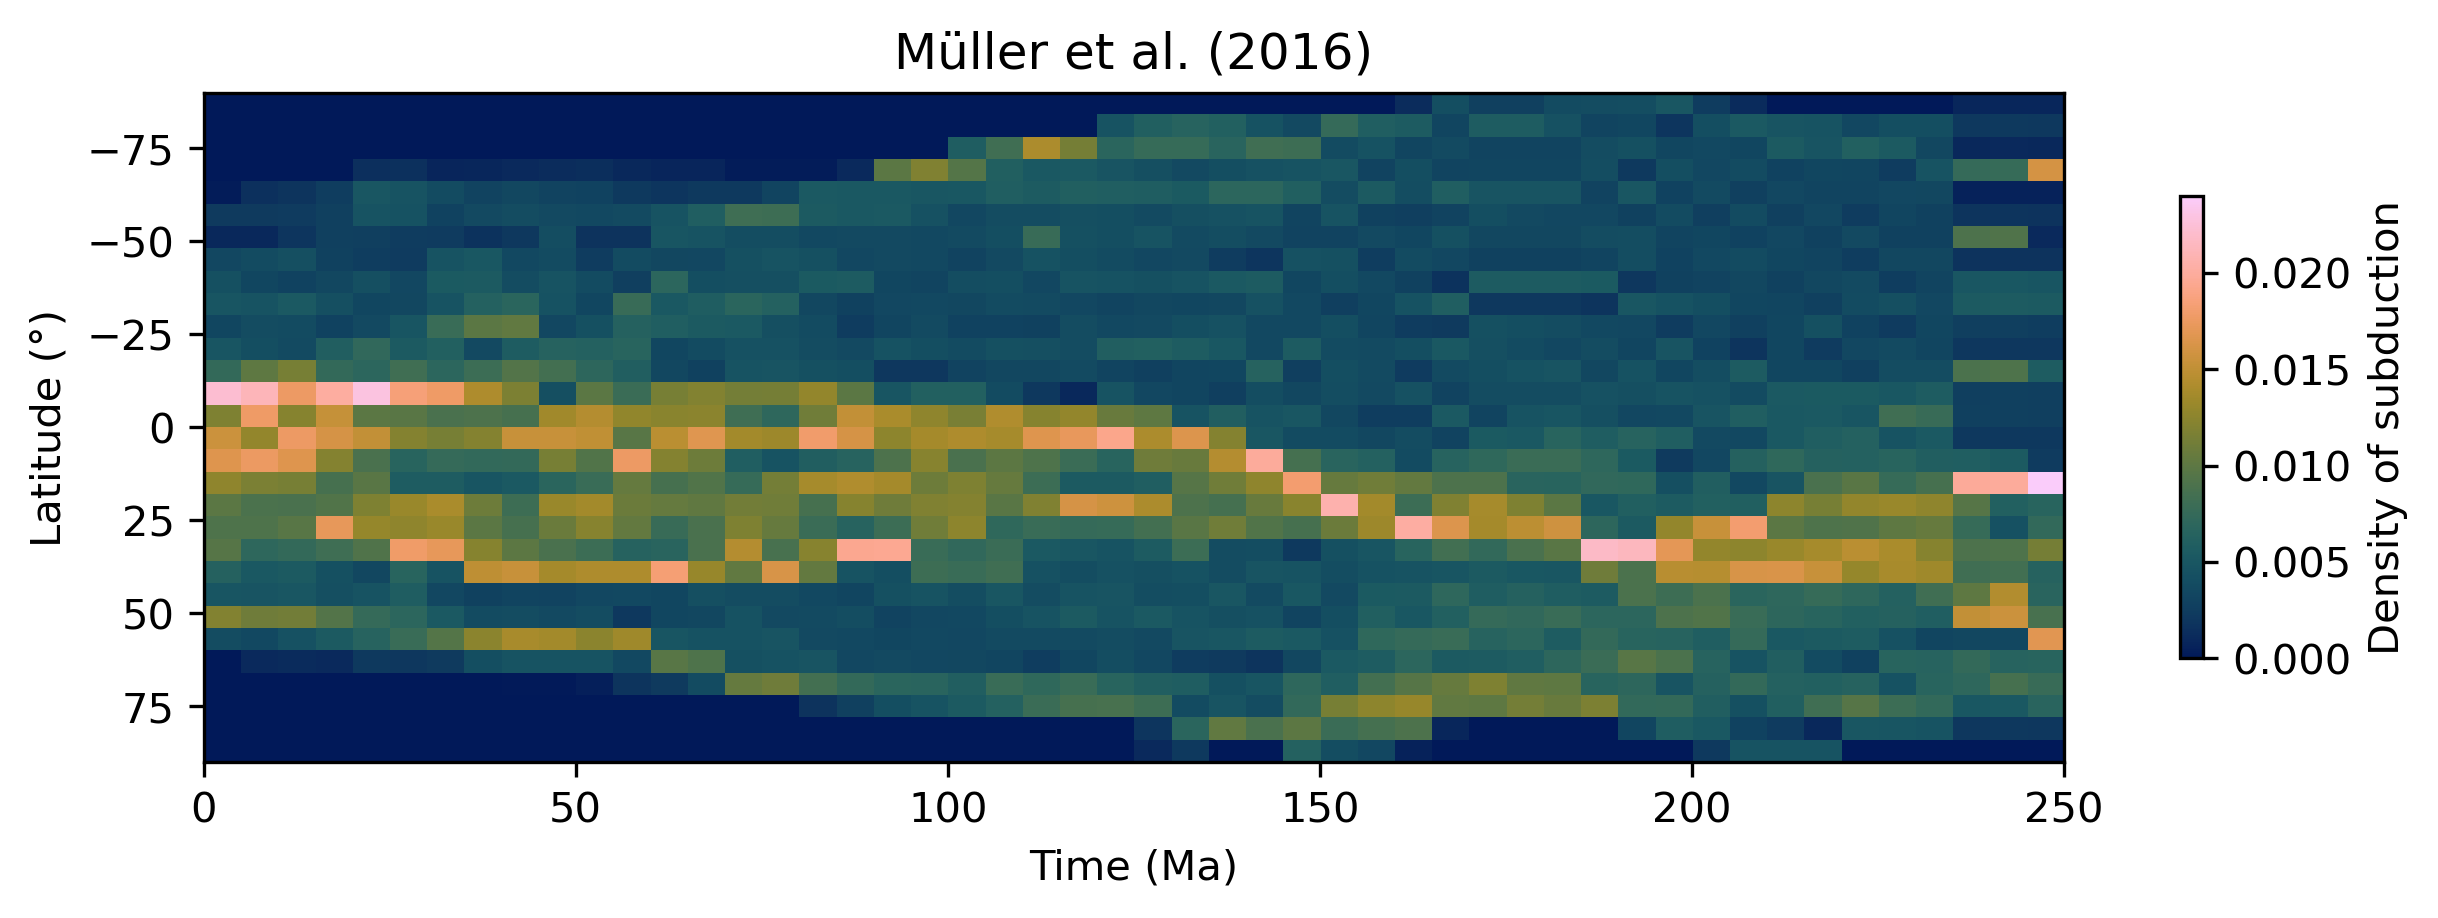

C:\Users\ilyas\Miniconda3\envs\pacific_vel\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


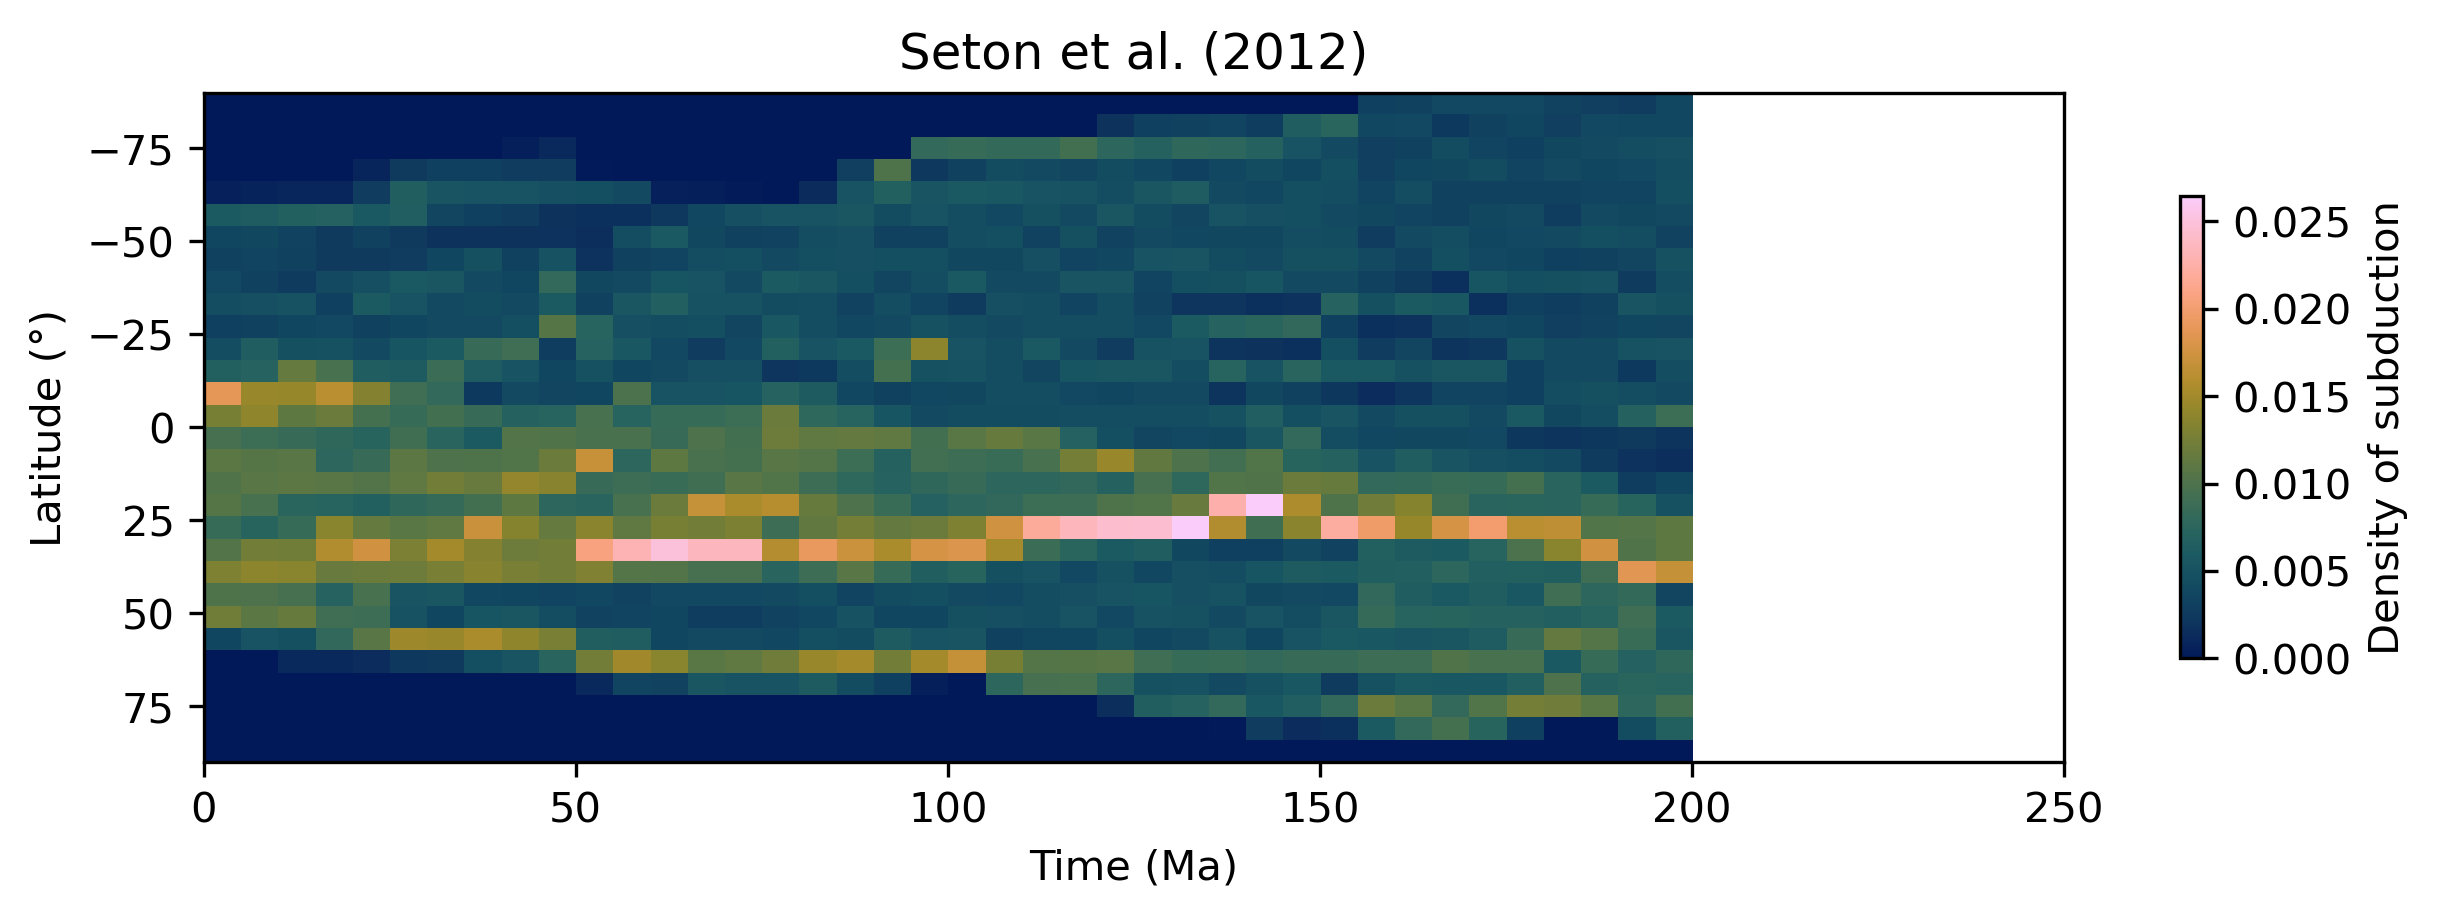

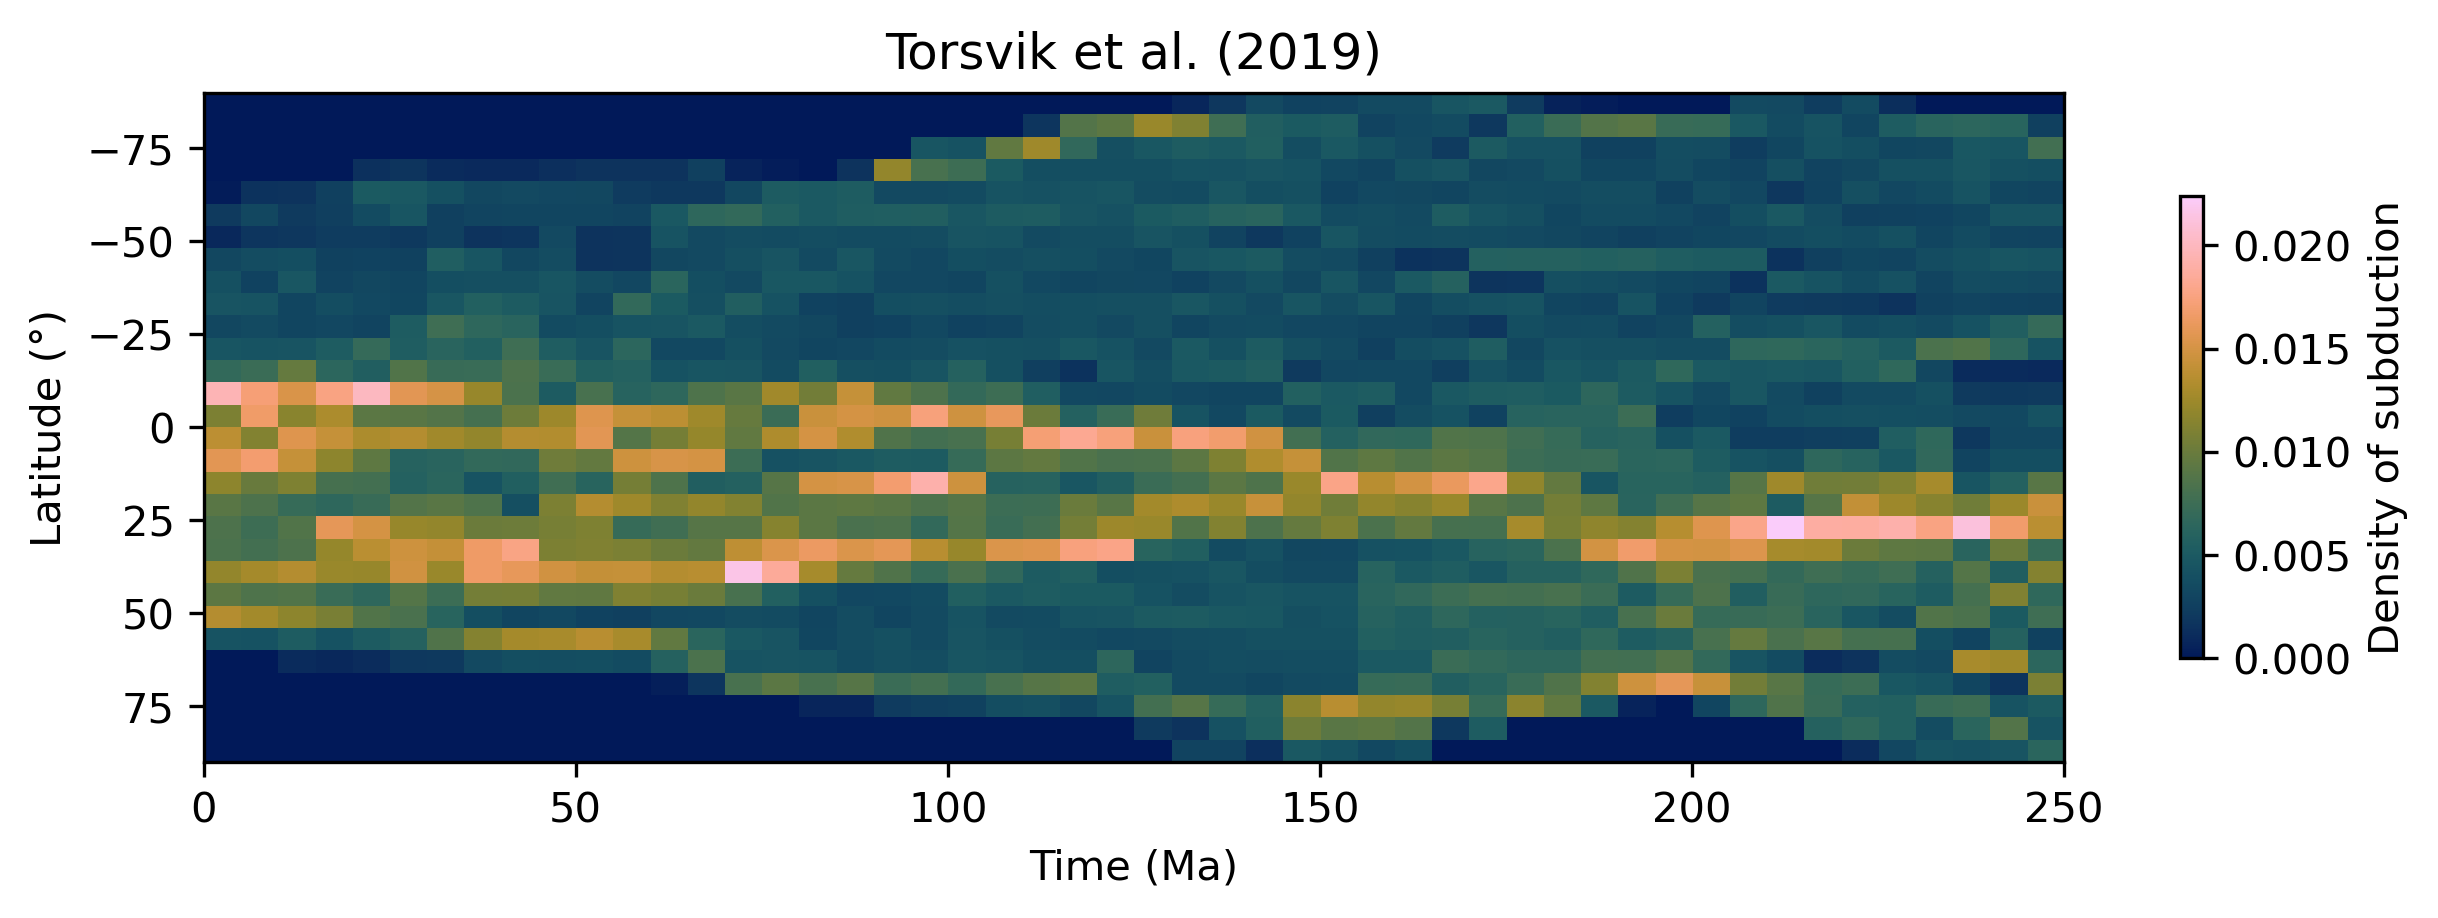

In [225]:
#Plot of density of subduction as a function of latitude
for m,plate_model in enumerate(L_plate_model):
    df = pd.read_csv('subduction_flux_data_'+plate_model+'.csv') 
    
    Nt=(stop-start)//delta_time
    nbins=30
    
    density = np.zeros((nbins, Nt))
    flux= np.zeros((Nt))
    
    for time, i in zip(range(start, stop+delta_time, delta_time), range(Nt)): 
        #Compute histogram
        hist, bin_edges = np.histogram(df[f'midpoint_lat_{time}'], bins=nbins, range=(-90,90), density=True, weights=df[f'width_{time}'])
        #print(hist)
        density[:,i]=hist
    
    fig = plt.figure(figsize=(10, 5), dpi=300)
    ax = fig.add_subplot(1, 1, 1)
    cmap=ax.imshow(density, cmap=cm.batlow, interpolation='none', extent=[start,stop,90,-90])
    ax.set_aspect(1/2)
    plt.colorbar(cmap, label='Density of subduction', shrink=0.4, ticks=[0,0.005,0.01,0.015,0.02,0.025])
    ax.set_xlabel('Time (Ma)')
    ax.set_ylabel('Latitude (°)')
    plt.title(plate_model_label[m])
    plt.savefig('figs/sub_density_'+plate_model+'')
    plt.show()
    

In [ ]:
def rms(L):
    s=0
    for e in L:
        s+=e**2
    return np.sqrt(s/len(L))

C:\Users\ilyas\AppData\Local\Temp\ipykernel_35616\2302022950.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  model_data = pd.read_csv('dmas_0_400Ma.dat', header=None, delimiter='     ')


0      547.446237
1      547.446237
2      547.446237
3      547.446237
4      547.446237
          ...    
405    514.740410
406    514.740410
407    514.740410
408    514.740410
409    514.740410
Name: 1, Length: 410, dtype: float64
nan found
nan found
nan found
nan found
nan found
nan found
nan found
nan found
nan found
nan found


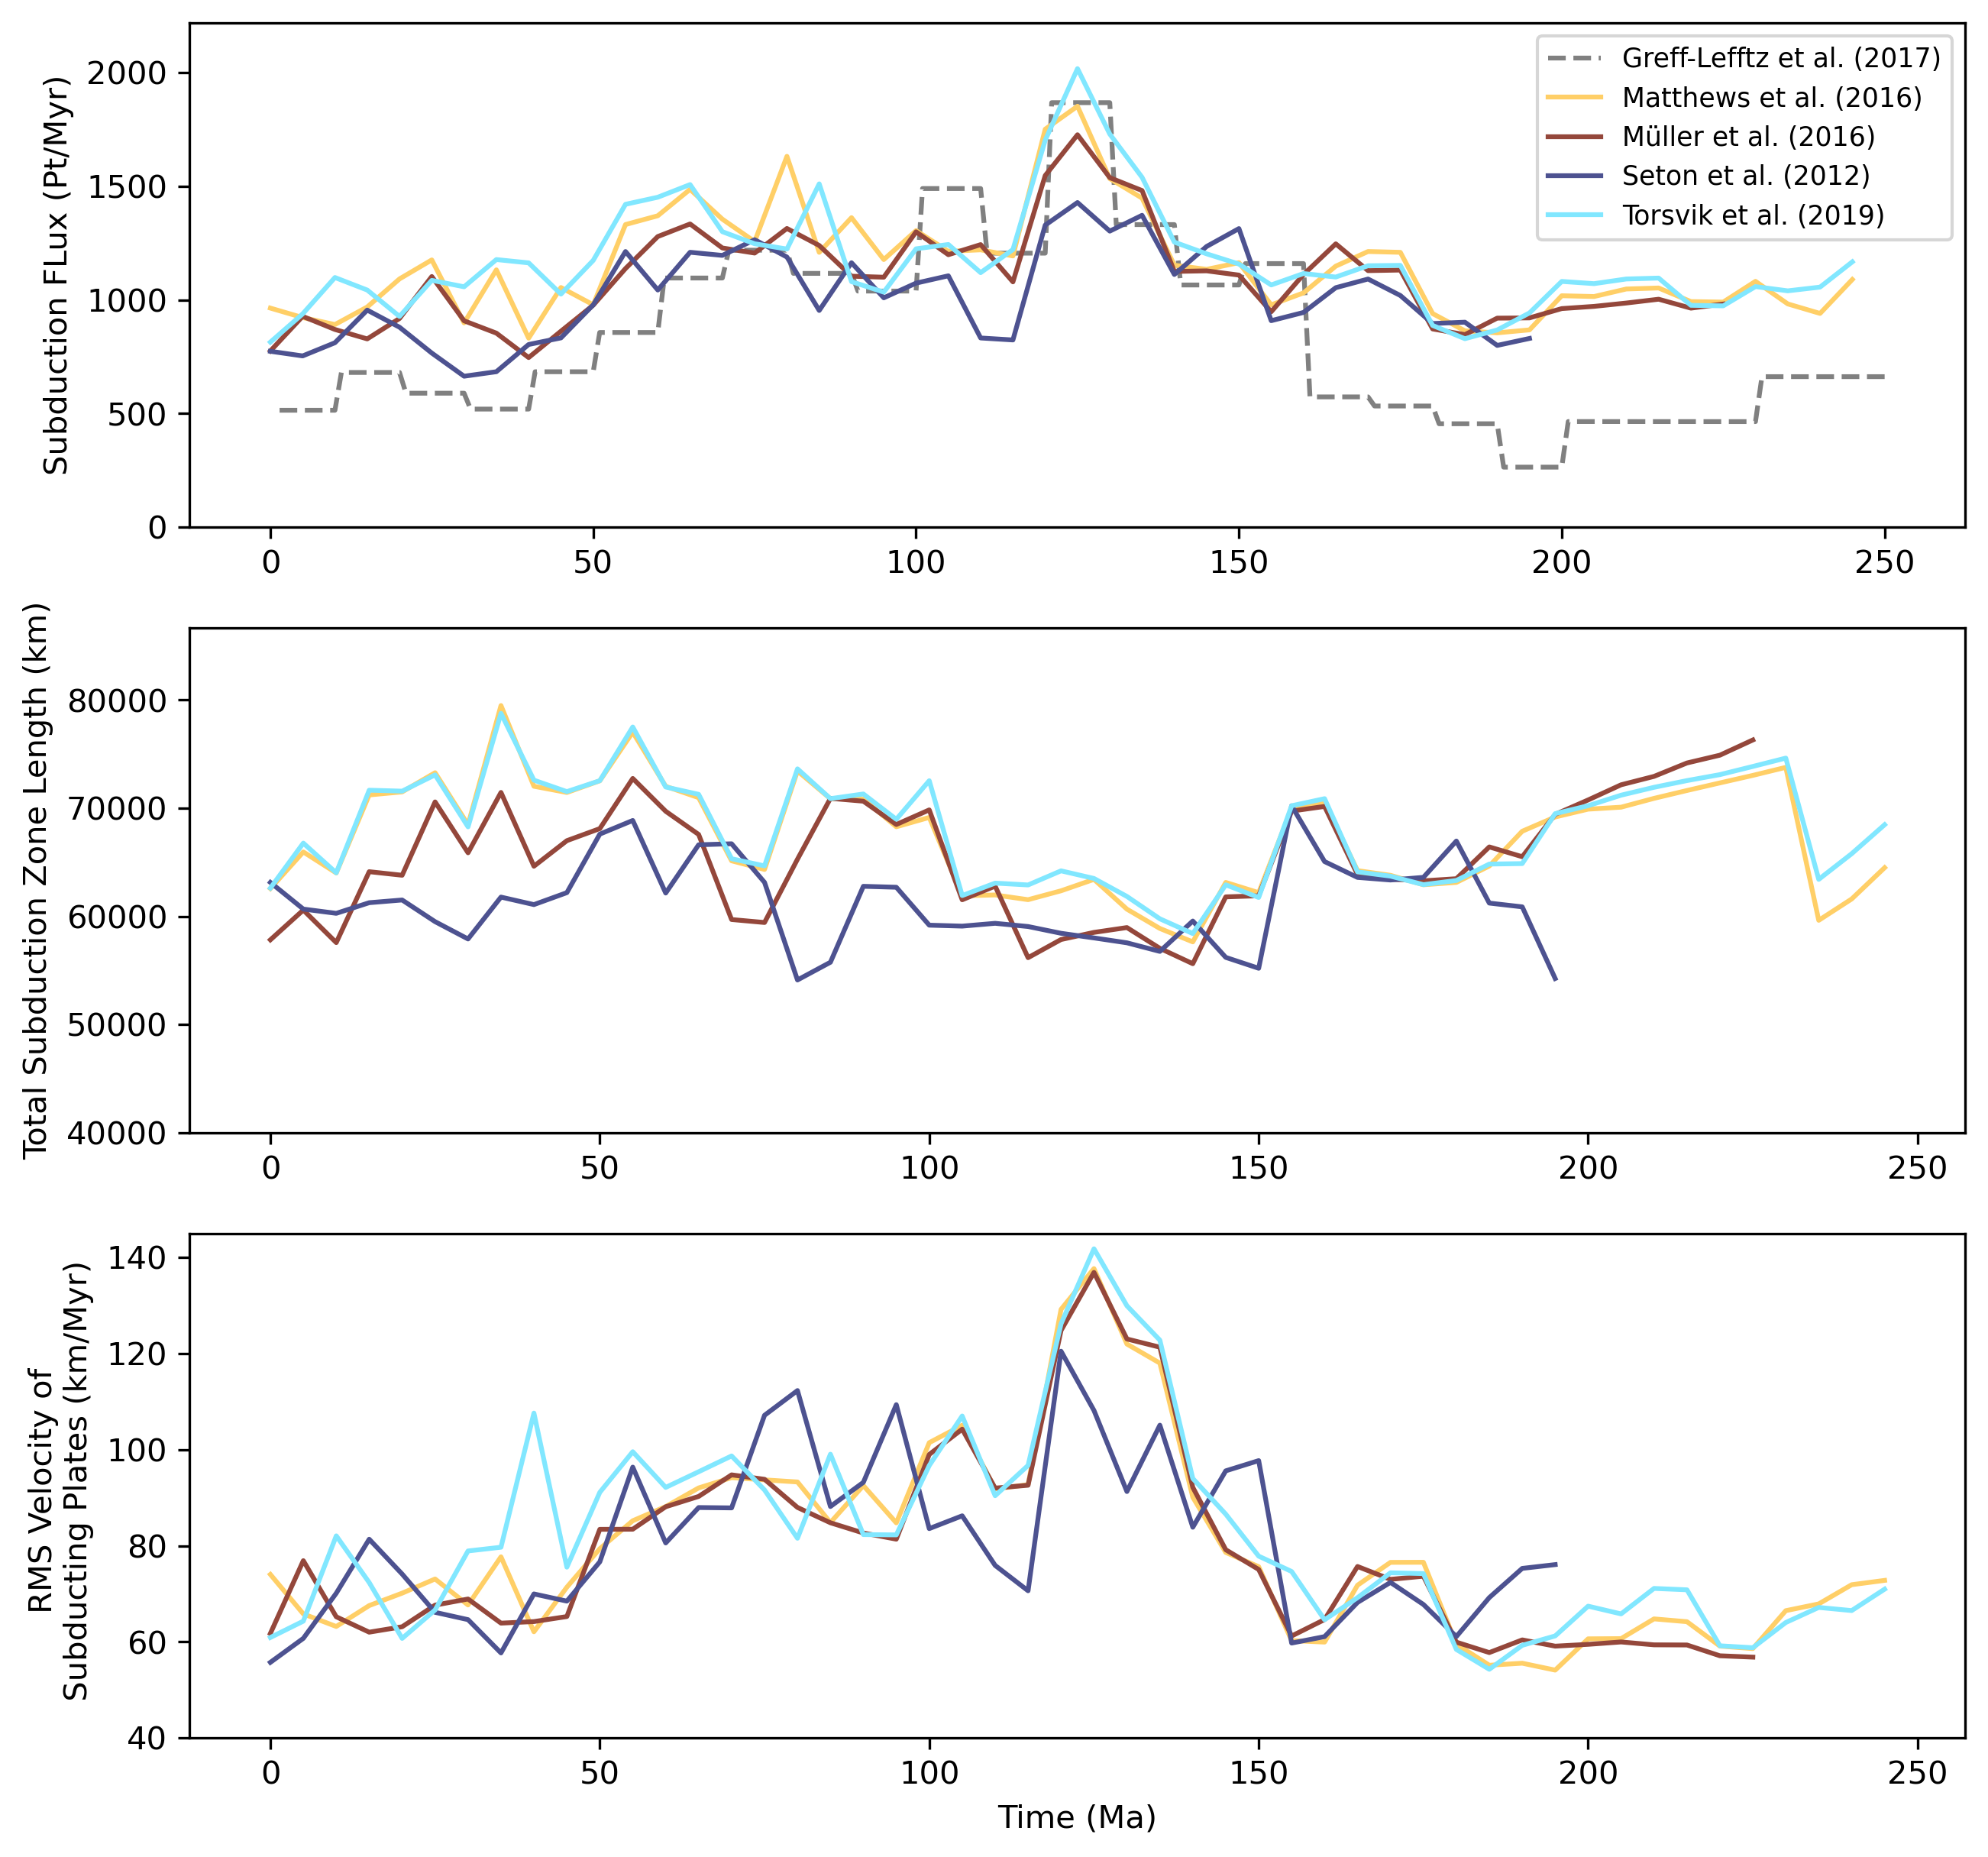

In [250]:
fig1 = plt.figure(figsize=[5*2,2.7*2*1.8],dpi=300)
ax1 = fig1.add_subplot(3, 1, 1)
ax2 = fig1.add_subplot(3, 1, 2)
ax3 = fig1.add_subplot(3, 1, 3)

#read and plot data from Greff_Lefftz et al. 2017
model_data = pd.read_csv('dmas_0_400Ma.dat', header=None, delimiter='     ')

i_stop = np.where(-model_data[0]==250.0)[0][0]  #we want to display the data only until 250Ma

ax1.plot(-model_data[0][i_stop:], model_data[1][i_stop:], '--', c='grey', label='Greff-Lefftz et al. (2017)')
#print(model_data[1])

max_flux=0
max_L=0

for m,plate_model in enumerate(L_plate_model):

    df = pd.read_csv('subduction_flux_data_'+plate_model+'.csv') 
    
    Nt=(stop-start)//delta_time
    
    flux= np.zeros((Nt))
    L= np.zeros((Nt))
    T=[]
    
    for time, i in zip(range(start, stop+delta_time, delta_time), range(Nt)):

        df_t = df[[f'midpoint_lon_{time}', f'midpoint_lat_{time}', f'velocity_{time}']]
        df_t = df_t.dropna()
    
        # Convert the column to actual tuples
        df_t[f'velocity_{time}'] = df_t[f'velocity_{time}'].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip() else None
        )
        
        V = df_t[f'velocity_{time}'].to_numpy()

        if len(V)==0:
            V_rms[i]=np.nan
            print('nan found')
        else:
            v_x = [point[0] for point in V]  # Get latitudes
            v_y = [point[1] for point in V]  # Get longitudes
    
            V_rms[i] = rms(np.sqrt(np.square(v_x) + np.square(v_y)))
            
        flux[i] = np.nansum(df[f'flux_{time}'].to_numpy()) /1e6  #flux is orginally in Pg/Myr so we put it in Pt/Myr
        L[i] = np.nansum(df[f'width_{time}'].to_numpy()) 
        T.append(time)

    L[flux==0]=np.nan
    V_rms[flux==0]=np.nan
    flux[flux==0]=np.nan

    max_flux = max(np.max(flux),max_flux)
    max_L = max(np.max(L),max_L)
    
    ax1.plot(T,flux, label=plate_model_label[m], c=colors[m])
    ax2.plot(T,L, label=plate_model_label[m], c=colors[m])
    ax3.plot(T,V_rms, label=plate_model_label[m], c=colors[m])

ax1.set_ylim(0, 1.1*max_flux)
ax2.set_ylim(40000, 1.1*max_L)
ax3.set_ylim(40,145)

ax3.set_xlabel('Time (Ma)')
ax1.set_ylabel('Subduction FLux (Pt/Myr)')
ax3.set_ylabel('RMS Velocity of \n Subducting Plates (km/Myr)')
ax2.set_ylabel('Total Subduction Zone Length (km)')
ax1.legend(ncols=1, loc='upper right', fontsize='small')

#fig1.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('figs/sub_flux_length_rms_vel_all')